# Graph Database Interface and Curve Parameter Predictor Guide

This will be a guide showing an example workflow of extracting tabular data from the Graph Database, training a Curve Parameter Predictor on that data, and making predictions with that model.

## Graph Database Interface

### Setup

First things first. Let's import all the functions from the GDBInterface.py file in the "root" folder.

In [1]:
from root.GDBInterface import *

### Segmenting Samples

The first part of the workflow is using the function segment_samples() to only get wanted samples based on a a list of passed rules. This can be thought as filtering the samples on the Graph Database so that only the samples that meet the passed conditions are returned.

For now, we want samples that are from batch "20231014_3A3X-B41-psk" and batch "20231115_2A3X-B43-psk", have colormetrics data, and have data related to the manufacture of the samples such as solute data.

Here are the rules that will get that data:

```"(n.batch_id = '20231014_3A3X-B41-psk' OR n.batch_id = '20231115_2A3X-B43-psk') and n.action = 'colormetrics'"```
- This rule fetches all samples that are within batches '20231014_3A3X-B41-psk' or '20231115_2A3X-B43-psk' and have a node that contains colormetrics data. Note that it is import to enclose strings within the rule with single quotes.

```"n.step_id ='1'"```
 - This rule fetches all samples that have data relating to the manufacture of those samples. This rule is essntially always required as there may be samples on the Graph Database that have colormetrics data but no other data due to some error in how the samples was pulled into the Graph Database. Note how that even though the step_id is a number within the Graph Database it is treated as a string so 1 is enclosed within single quotes.
 
While we won't use this rule for this scenario another example of a rule is fetching all samples that have a pl_intensity_0 greater than 500 and a pl_fwhm_0 less than 0.1:

```(n.pl_intensity_0 > 500 AND n.pl_fwhm_0 < 0.1)```

Below we put the two rules/conditions in a list called 'rules' and then pass that list to segment_samples(). This function returns a set of (batch_id, sample_id) pairs. Depending on how busy the NAS is this function can takes mere seconds or close to a minute. 

There might be a warning saying "Samples in this segment have different number of nodes. Tabularizing this segment is not advised." This can be due to many reasons and may be ok depending on the what features are extracted fromt the Graph Database. Since we are only extracting data about solutes this is ok. A warming only indicates that some samples have different numbers of solutes. In the tabularization these missing values are filled with 0.0

In [2]:
rules = ["(n.batch_id = '20231014_3A3X-B41-psk' OR n.batch_id = '20231115_2A3X-B43-psk') and n.action = 'colormetrics'",
         "n.step_id ='1'"]

samples = segment_samples(rules)

samples

/home/omicron3808/Fenning Solar Work/root/GDBInterface.py:146: UserWarning: Samples in this segment have different number of nodes. Tabularizing this segment is not advised.
  warnings.warn("Samples in this segment have different number of nodes. Tabularizing this segment is not advised.")


{('20231014_3A3X-B41-psk', 'sample0'),
 ('20231014_3A3X-B41-psk', 'sample1'),
 ('20231014_3A3X-B41-psk', 'sample10'),
 ('20231014_3A3X-B41-psk', 'sample11'),
 ('20231014_3A3X-B41-psk', 'sample12'),
 ('20231014_3A3X-B41-psk', 'sample13'),
 ('20231014_3A3X-B41-psk', 'sample14'),
 ('20231014_3A3X-B41-psk', 'sample15'),
 ('20231014_3A3X-B41-psk', 'sample16'),
 ('20231014_3A3X-B41-psk', 'sample18'),
 ('20231014_3A3X-B41-psk', 'sample19'),
 ('20231014_3A3X-B41-psk', 'sample2'),
 ('20231014_3A3X-B41-psk', 'sample20'),
 ('20231014_3A3X-B41-psk', 'sample21'),
 ('20231014_3A3X-B41-psk', 'sample23'),
 ('20231014_3A3X-B41-psk', 'sample24'),
 ('20231014_3A3X-B41-psk', 'sample25'),
 ('20231014_3A3X-B41-psk', 'sample26'),
 ('20231014_3A3X-B41-psk', 'sample27'),
 ('20231014_3A3X-B41-psk', 'sample28'),
 ('20231014_3A3X-B41-psk', 'sample29'),
 ('20231014_3A3X-B41-psk', 'sample3'),
 ('20231014_3A3X-B41-psk', 'sample30'),
 ('20231014_3A3X-B41-psk', 'sample31'),
 ('20231014_3A3X-B41-psk', 'sample32'),
 ('2

### Tabularizing Samples

Now that we have the list of our wanted samples we need to turn the data of these samples residing on the Graph Database into a tabular format.

We will use the function tabularize_samples() to do this. This function has three parameters: 'samples' which is a list or set of (batch_id, sample_id) pairs, include_fitted_metrics which is a boolean that indicates whether you want pl data to be included in the returned DataFrame (this defaults to True), and fitted_metrics_only which is a boolean that indicates whether you want *only* pl data in the DataFrame (this defaults to False).

We want a model where we can test potentional solute concentrations. So, in this scenario we do not want pl data so include_fitted_metrics will be set to False.

As before, depending on how busy the NAS is this function can takes mere seconds are close to a minute.

A note on what features are extracted from the Graph Database: Right now only data about solutes, curve parameters, and pl data if requested are extracted from the Graph Database. This can be changed in the function create_row() within GDBInterface.py. 

For example, if you want data about the solution mixes you can change ```if i['chem_type'] == 'solution' and not fitted_metrics_only and False:``` to ```if i['chem_type'] == 'solution' and not fitted_metrics_only:```

In [3]:
df = tabularize_samples(samples, include_fitted_metrics=False)

df

Tabularizing Samples:   0%|          | 0/146 [00:00<?, ?it/s]

,batch_id,sample_id,solute_FA,solute_Cs,solute_I,solute_Br,solute_Cl,curve_L,curve_x0,curve_k
0,20231014_3A3X-B41-psk,sample1,0.78,0.22,2.40,0.450,0.150,1.0,78.330460,0.024673
1,20231014_3A3X-B41-psk,sample34,0.78,0.22,2.85,0.150,0.000,1.0,96.503294,0.017722
2,20231115_2A3X-B43-psk,sample102,0.78,0.22,2.82,0.175,0.000,1.0,446.717253,0.008721
3,20231115_2A3X-B43-psk,sample9,0.78,0.22,2.54,0.420,0.045,1.0,423.990985,0.010618
4,20231014_3A3X-B41-psk,sample11,0.78,0.22,2.55,0.300,0.150,1.0,436.355976,0.006584
...,...,...,...,...,...,...,...,...,...,...
141,20231115_2A3X-B43-psk,sample74,0.78,0.22,2.54,0.465,0.000,1.0,351.098139,0.006182
142,20231115_2A3X-B43-psk,sample26,0.78,0.22,2.70,0.300,0.000,1.0,464.114812,0.008164
143,20231115_2A3X-B43-psk,sample47,0.78,0.22,2.82,0.175,0.000,1.0,381.733261,0.011852
144,20231115_2A3X-B43-psk,sample44,0.78,0.22,2.63,0.365,0.000,1.0,384.071512,0.008176


We could do some data analysis on the DataFrame but for now let's just move on to training a model on this data.

## Curve Parameter Predictor

This is a model that predics 'curve_x0' based on features in the passed DataFrame and predicts 'curve_k' based on 'curve_x0'

### Setup

First things first. Let's import all the functions from the CurveParamPredictor.py file in the "root" folder.

In [4]:
from root.CurveParamPredictor import *

### Initializing CurveParamPredictor

The class that will be used to create a model, train on data, and make predictions is CurveParamPredictor(). This class has one initialization parameter which is 'folds'. 'folds' is used to change how many folds are used in cross-fold validation when chosing the best hyperparameters for a regressor. Its default value is 10 but in our case lets say we only want 5 folds.

In [5]:
cpp = CurveParamPredictor(folds = 5)

### Training CurveParamPredictor

Now that the CurveParamPredictor has been initialized as 'cpp' we can pass the dataset to it using .train(). Unlike models in sklearn, for example, the entire dataset is passed to the model during training, not a dataframe for features and a seperate dataframe for the target variables. All train-test splits are done within the model so splitting the data outside the model is unnecessary.

In [6]:
cpp.train(df)

Now that the model has been trained we can use the function generate_parity_plots() to see a visual of well the model perfoms on the test set. The graphs produced by this function are saved locally as PNGs.

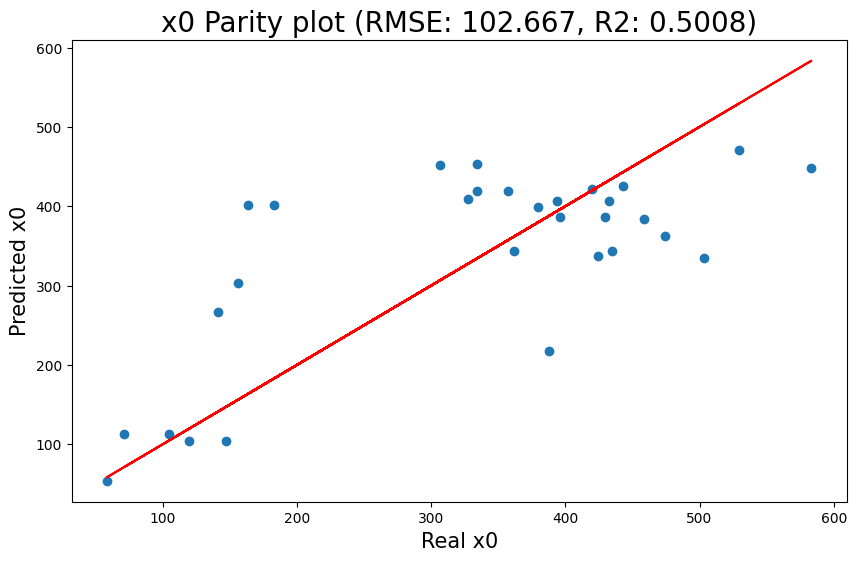

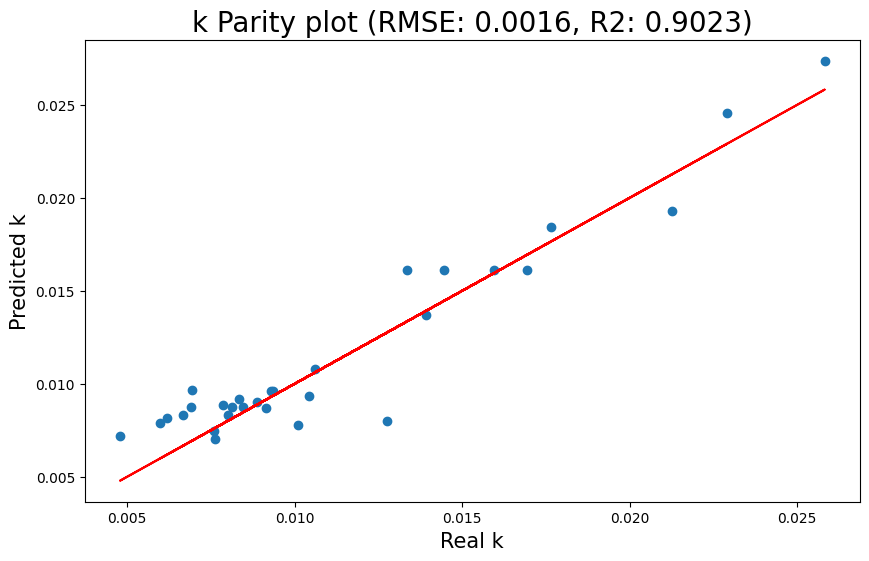

In [7]:
cpp.generate_parity_plots()

As can be seen our model is not great at predicting 'curve_x0' which is the hour where the film is half degraded. However, it is good at predicting 'curve_k' which means that each predicted 'curve_x0' will have a mostly correct corrosponding 'curve_k'.

### Using CurveParamPredictor to predict curve parameters

Now that the model is trained we can use it to predict curve parameters based on hypothetical solute compositions.

In [8]:
to_pred = pd.DataFrame(columns = cpp.X.columns)

to_pred

,solute_FA,solute_Cs,solute_I,solute_Br,solute_Cl


The above shows us what features we have to fill to predict the curve parameters. Now let us fill out some hypothetical solute compositions. Note that in this scenario 'solute_I', 'solute_Br', and 'solute_Cl' must sum to 3.0.

In [12]:
to_pred['solute_FA'] = [0.78, 0.78]

to_pred['solute_Cs'] = [0.22, 0.22]

to_pred['solute_I'] = [2.4, 2.3]

to_pred['solute_Br'] = [0.6, 0.2]

to_pred['solute_Cl'] = [0.0, 0.5]

to_pred

,solute_FA,solute_Cs,solute_I,solute_Br,solute_Cl
0,0.78,0.22,2.4,0.6,0.0
1,0.78,0.22,2.3,0.2,0.5


Now that we have filled out the DataFrame 'to_pred' with hypothetical compositions we can predict their resulting curves by using .predict()

In [14]:
pred_params = cpp.predict(to_pred)

pred_params

array([[1.00000000e+00, 4.01757142e+02, 9.48816614e-03],
       [1.00000000e+00, 2.50831482e+02, 7.82080832e-03]])

### Visualizing predicted curves

Now that we have the predicted curve parameters we can visualize the curves using the logistic() function below. When graphing the curve it is reccomended that you scale the curve using ```(pred_curve-np.min(pred_curve))/(pred_params[i][0]-np.min(pred_curve))``` which scales the curve from 0 to 1.

{'solute_FA': 0.78, 'solute_Cs': 0.22, 'solute_I': 2.4, 'solute_Br': 0.6, 'solute_Cl': 0.0}


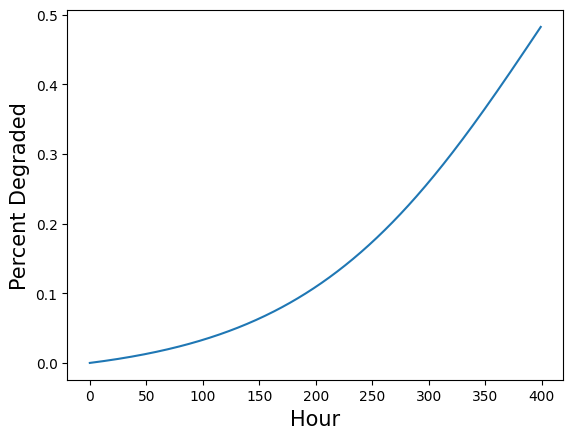

{'solute_FA': 0.78, 'solute_Cs': 0.22, 'solute_I': 2.3, 'solute_Br': 0.2, 'solute_Cl': 0.5}


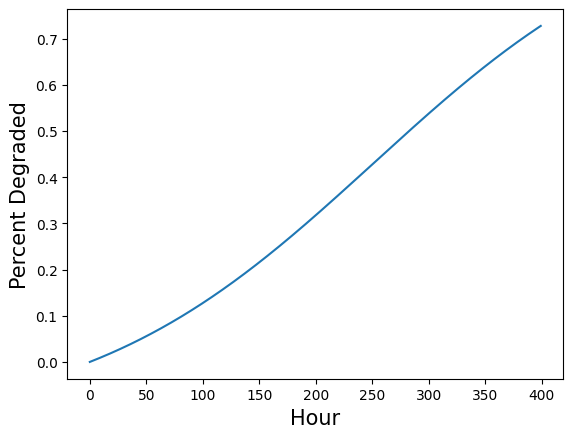

In [25]:
def logistic(x, L=1, x_0=0, k=1):
    return L / (1 + np.exp(-k * (x - x_0)))

    
for i in range(len(pred_params)):
    print(to_pred.to_dict(orient = 'records')[i])
    
    
    pred_curve = logistic(range(0,400), *pred_params[i])
    
    pred_curve = (pred_curve-np.min(pred_curve))/(pred_params[i][0]-np.min(pred_curve))
    
    plt.plot(range(0,400), pred_curve)
    plt.xlabel('Hour')
    plt.ylabel('Percent Degraded')
    plt.show()